# Import statements 

In [11]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import adam_v2

In [13]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
z_dim = 100

# Generator

In [14]:
def build_generator(img_shape, z_dim):
  model = Sequential()
  model.add(Dense(128, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(28 * 28 * 1, activation='tanh'))
  model.add(Reshape(img_shape))
  return model

# Discriminatore

In [15]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation='sigmoid'))
  return model

# Building and compilling the GAN

In [16]:
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [17]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(),metrics=['accuracy'])
generator = build_generator(img_shape, z_dim)
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam())

# GAN Training Loop

In [18]:
losses = []
accuracies = []
iteration_checkpoints = []
def train(iterations, batch_size, sample_interval):
  (X_train, _), (_, _) = mnist.load_data()# Loads the MNIST dataset
  X_train = X_train / 127.5 - 1.0 # Rescales [0, 255] grayscale pixel values to [–1, 1]
  X_train = np.expand_dims(X_train, axis=3)
  real = np.ones((batch_size, 1)) # Labels for real images: all 1s
  fake = np.zeros((batch_size, 1)) # Labels for fake images: all 0s
  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size) # Gets a random batch of real images
    imgs = X_train[idx]
    z = np.random.normal(0, 1, (batch_size, 100)) #Generates a batch of fake images
    gen_imgs = generator.predict(z)
    d_loss_real = discriminator.train_on_batch(imgs, real)# Trains the Discriminator
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    z = np.random.normal(0, 1, (batch_size, 100)) # Generates a batch of fake images
    gen_imgs = generator.predict(z) # Trains the Generator
    g_loss = gan.train_on_batch(z, real)
    if (iteration + 1) % sample_interval == 0:
      # Saves losses and accuracies so they can be plotted after training
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)
      #Outputs training progress
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      sample_images(generator) # Outputs a sample of generated images

In [19]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim)) # Sample random noise
  gen_imgs = generator.predict(z)# Generates images from random noise
  gen_imgs = 0.5 * gen_imgs + 0.5 # Rescales image pixel values to [0, 1]
  fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4, 4),sharey=True,sharex=True) # Sets image grid
  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray') # Outputs a grid of images
      axs[i, j].axis('off')
      cnt += 1

# Running the model

1000 [D loss: 0.040948, acc.: 100.00%] [G loss: 3.713062]
2000 [D loss: 0.152808, acc.: 93.75%] [G loss: 5.475526]
3000 [D loss: 0.118243, acc.: 95.31%] [G loss: 5.535659]
4000 [D loss: 0.228354, acc.: 92.19%] [G loss: 4.826472]
5000 [D loss: 0.063982, acc.: 96.88%] [G loss: 5.682617]
6000 [D loss: 0.194700, acc.: 91.41%] [G loss: 4.344729]
7000 [D loss: 0.219842, acc.: 91.80%] [G loss: 4.081117]
8000 [D loss: 0.328820, acc.: 85.16%] [G loss: 4.052098]
9000 [D loss: 0.259132, acc.: 89.84%] [G loss: 3.591112]
10000 [D loss: 0.403743, acc.: 82.81%] [G loss: 3.249040]
11000 [D loss: 0.171995, acc.: 94.14%] [G loss: 4.192885]
12000 [D loss: 0.450419, acc.: 81.64%] [G loss: 2.780912]
13000 [D loss: 0.349565, acc.: 87.11%] [G loss: 3.126112]
14000 [D loss: 0.302623, acc.: 86.72%] [G loss: 3.595205]
15000 [D loss: 0.436279, acc.: 80.08%] [G loss: 2.201191]
16000 [D loss: 0.278618, acc.: 88.67%] [G loss: 3.145057]
17000 [D loss: 0.408898, acc.: 83.59%] [G loss: 2.362399]
18000 [D loss: 0.30548

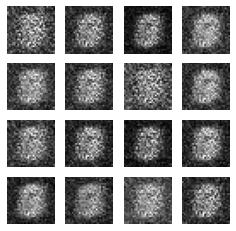

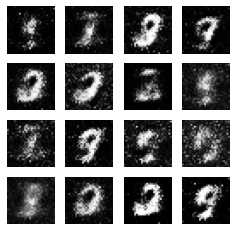

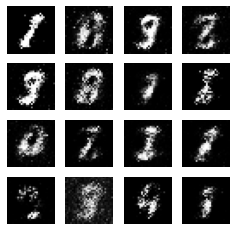

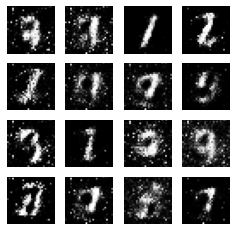

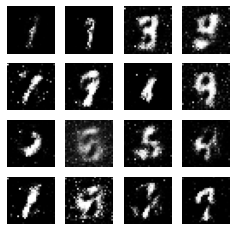

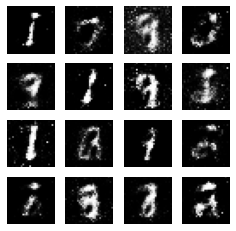

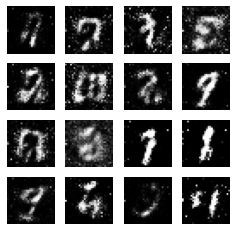

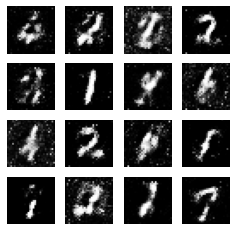

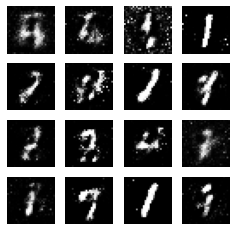

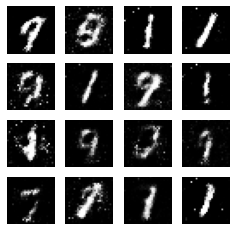

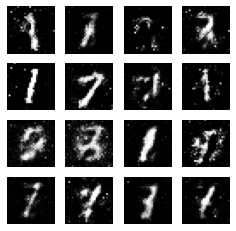

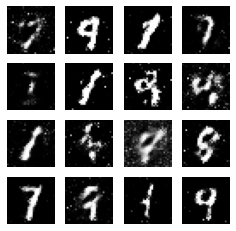

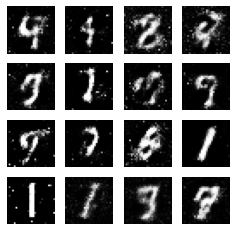

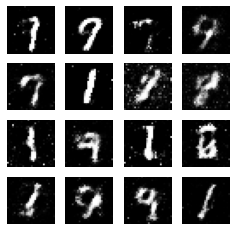

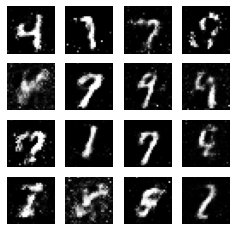

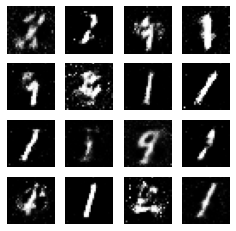

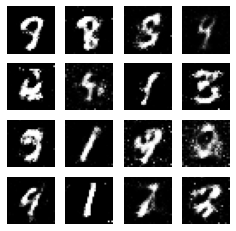

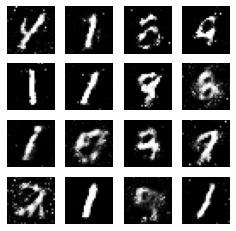

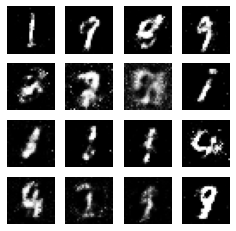

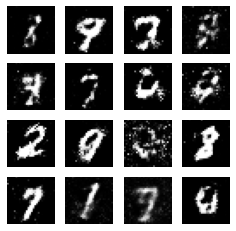

In [20]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)

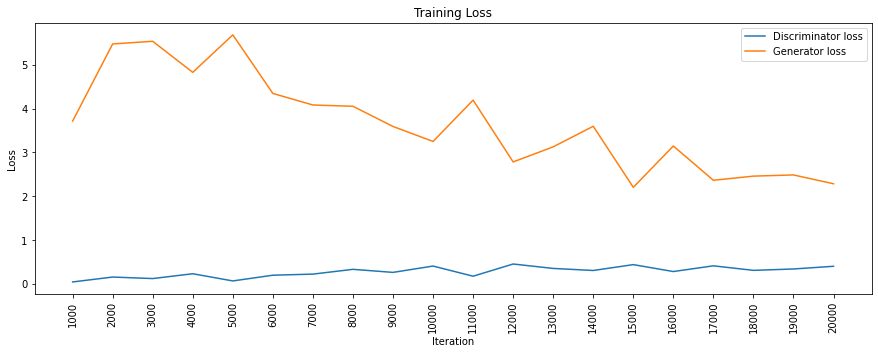

In [21]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

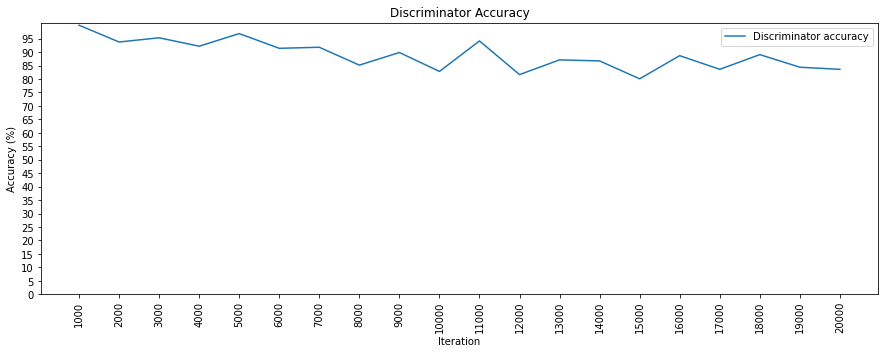

In [22]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()